In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Cuda kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

df = pd.read_csv('dataset.csv')

labels = pd.read_csv("dataset.csv")
labels = labels["label"].values.tolist()

Kullanılan cihaz: cuda


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
import os

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
tokenizer2 = AutoTokenizer.from_pretrained("TURKCELL/roberta-base-turkish-uncased")

metinler = df["text"].values.tolist()

# Tokenize et ve attention mask'i al
encodings = tokenizer2(
    metinler,
    padding=True,
    truncation=True,
    max_length=512,  # Bu satırı ekleyin
    return_tensors='pt'
)
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight factor for each class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_softmax = F.log_softmax(inputs, dim=1)
        ce_loss = F.nll_loss(log_softmax, targets, weight=self.alpha, reduction='none')

        # Get the probabilities for the target class
        p_t = torch.exp(-ce_loss)

        # Apply the focusing term
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
# Sabit değerler
MAX_LEN = 128
BATCH_SIZE = 96
EPOCHS = 5
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "dbmdz/bert-base-turkish-cased"  # BERTurk modeli
MODEL_NAME2 = "TURKCELL/roberta-base-turkish-uncased"  # TARBERT modeli

In [ ]:
class BERTurkBiGRUEnsemble(nn.Module):
    def __init__(self, dropout_rate=DROPOUT_RATE, freeze=False):
        super(BERTurkBiGRUEnsemble, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME2)
        self.dropout = nn.Dropout(dropout_rate)


        self.hidden_size = 128
        self.bigru = nn.GRU(
            input_size=self.bert.config.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.classifier = nn.Linear(self.hidden_size * 2, 2)  # Binary classification

        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # BERT encoding
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Get sequence output instead of just pooled output for GRU
        sequence_output = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]
        sequence_output = self.dropout(sequence_output)

        # Pass through BiGRU
        gru_output, _ = self.bigru(sequence_output)
        # gru_output shape: [batch_size, seq_len, hidden_size*2]

        # Use the last hidden state of the BiGRU for classification
        # Get the indices of the last tokens in each sequence based on attention mask
        last_token_indices = attention_mask.sum(dim=1) - 1

        # Gather the last hidden states for each sequence
        batch_size = gru_output.shape[0]
        last_hidden_states = torch.zeros(batch_size, gru_output.shape[2]).to(DEVICE)
        for i in range(batch_size):
            last_hidden_states[i] = gru_output[i, last_token_indices[i], :]

        # Pass through final classifier
        logits = self.classifier(last_hidden_states)

        return logits

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels=None):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item


class EarlyStoppingWithClassF1:
    def __init__(self, patience=5, min_delta=0.001, class_index=1, class_weight=0.5):
        """
        Early stopping that monitors both overall F1 and Class 1 F1 scores

        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change in monitored metrics to qualify as improvement
            class_index: Index of the class to monitor (1 for Class 1)
            class_weight: Weight given to class F1 vs overall F1 (0.5 means equal weight)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.class_index = class_index
        self.class_weight = class_weight
        self.counter = 0
        self.best_score = None
        self.best_class_f1 = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, model, val_overall_f1, val_class_f1s):
        """
        Args:
            model: Model to save if improvement
            val_overall_f1: Overall validation F1 score
            val_class_f1s: F1 scores for each class (list or array)
        """
        # Get the F1 score for the specific class we're monitoring
        class_f1 = val_class_f1s[self.class_index]

        # Calculate a combined score that considers both overall F1 and class F1
        combined_score = (1 - self.class_weight) * val_overall_f1 + self.class_weight * class_f1

        if self.best_score is None or self.best_class_f1 is None:
            # First epoch
            self.best_score = combined_score
            self.best_class_f1 = class_f1
            self.save_checkpoint(model)
        elif combined_score < self.best_score + self.min_delta:
            # Score didn't improve enough
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Score improved, but also check if Class 1 F1 didn't decrease significantly
            class_f1_decrease = self.best_class_f1 - class_f1

            # Only consider it an improvement if Class 1 F1 didn't drop too much
            if class_f1_decrease <= self.min_delta:
                print(f'Validation score improved! Overall F1: {val_overall_f1:.4f}, Class 1 F1: {class_f1:.4f}')
                self.best_score = combined_score
                self.best_class_f1 = class_f1
                self.save_checkpoint(model)
                self.counter = 0
            else:
                # Class 1 F1 dropped too much, don't reset counter
                print(f'Overall score improved but Class 1 F1 dropped too much (from {self.best_class_f1:.4f} to {class_f1:.4f})')
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    def save_checkpoint(self, model):
        """Save model weights when validation performance improves"""
        self.best_weights = copy.deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        """Restore model to best weights"""
        model.load_state_dict(self.best_weights)

def train_model(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0,
                num_epochs=10, patience=3, class_f1_weight=0.6, learning_rate=2e-5):
    """
    Train model with Focal Loss and balanced early stopping

    Args:
        model: Model to train
        train_dataloader: Training data loader
        test_dataloader: Validation/test data loader
        class_weights: Dictionary mapping class indices to weights (e.g., {0: 1, 1: 6})
        gamma: Focal loss focusing parameter
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience
        class_f1_weight: Weight to give to Class 1 F1 score in early stopping
        learning_rate: Learning rate for optimizer

    Returns:
        trained_model: The trained model
        history: Dictionary containing training metrics
    """
    # Set up device
    device = next(model.parameters()).device

    # Create alpha tensor for focal loss based on class weights
    if class_weights is not None:
        num_classes = len(class_weights)
        alpha = torch.ones(num_classes)
        for cls_idx, weight in class_weights.items():
            alpha[cls_idx] = weight
        alpha = alpha.to(device)
    else:
        alpha = None

    # Initialize Focal Loss
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Set up early stopping
    early_stopping = EarlyStoppingWithClassF1(
        patience=patience,
        class_index=1,  # Monitor Class 1 F1
        class_weight=class_f1_weight
    )

    # Track metrics
    history = {
        'train_loss': [],
        'train_f1': [],
        'train_class_f1s': [],
        'val_loss': [],
        'val_f1': [],
        'val_class_f1s': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store predictions and labels for metrics
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_loss = train_loss / len(train_dataloader)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_class_f1s = f1_score(train_labels, train_preds, average=None)

        # Save training metrics
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_class_f1s'].append(train_class_f1s.tolist())

        # Validation phase
        if test_dataloader is not None:
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for batch in test_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Store predictions and labels for metrics
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_loss = val_loss / len(test_dataloader)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            val_class_f1s = f1_score(val_labels, val_preds, average=None)

            # Save validation metrics
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_class_f1s'].append(val_class_f1s.tolist())

            # Print epoch results
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Class 1 F1: {val_class_f1s[1]:.4f}')

            # Early stopping check
            early_stopping(model, val_f1, val_class_f1s)

            if early_stopping.early_stop:
                print("Early stopping triggered")
                # Restore best weights
                early_stopping.restore_best_weights(model)
                break
        else:
            # Print training metrics when no validation set provided
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')

    # Load best weights if early stopping was used
    if test_dataloader is not None and early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)

    return model, history

# Partially freeze BERT (freeze only the first N layers)
def freeze_bert_layers(model, num_layers_to_freeze):
    # Freeze embeddings
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False

    # Freeze the first num_layers_to_freeze encoder layers
    for layer in list(model.bert.encoder.layer)[:num_layers_to_freeze]:
        for param in layer.parameters():
            param.requires_grad = False


def train_model1(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0):
    """Modeli eğitme ve metrikleri kaydetme"""
    # Optimizer ve scheduler oluştur
    optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Focal Loss fonksiyonu - class weights kullanarak dengesiz veri için
    if class_weights is not None:
        weights = torch.tensor(list(class_weights.values())).float().to(DEVICE)
        loss_fn = FocalLoss(alpha=weights, gamma=gamma)
    else:
        loss_fn = FocalLoss(gamma=gamma)

    # Eğitim metriklerini kaydetmek için history sözlüğü
    history = {
        "train_loss": [], "train_f1": [], "train_acc": [],
        "train_class_0_acc": [], "train_class_1_acc": []
    }

    if test_dataloader:
        history.update({
            "test_loss": [], "test_f1": [], "test_acc": [],
            "test_class_0_acc": [], "test_class_1_acc": []
        })

    # Eğitim döngüsü
    best_train_f1 = 0
    for epoch in range(EPOCHS):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"{'='*50}")

        # Eğitim aşaması
        model.train()
        train_predictions = []
        train_true_labels = []
        train_loss = 0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

            # Training performans hesaplaması için tahminleri topla
            _, preds = torch.max(outputs, dim=1)
            train_predictions.extend(preds.cpu().tolist())
            train_true_labels.extend(labels.cpu().tolist())

        # Eğitim metriklerini hesapla
        train_metrics = calculate_metrics(train_true_labels, train_predictions)
        train_metrics["loss"] = train_loss / len(train_dataloader)

        # Test metriklerini hesapla (eğer test_dataloader verilmişse)
        if test_dataloader:
            test_metrics = evaluate_model(model, test_dataloader, loss_fn)

        # Metrikleri history'e kaydet
        history["train_loss"].append(train_metrics["loss"])
        history["train_f1"].append(train_metrics["f1_weighted"])
        history["train_acc"].append(train_metrics["accuracy"])
        history["train_class_0_acc"].append(train_metrics["class_0_acc"])
        history["train_class_1_acc"].append(train_metrics["class_1_acc"])

        if test_dataloader:
            history["test_loss"].append(test_metrics["loss"])
            history["test_f1"].append(test_metrics["f1_weighted"])
            history["test_acc"].append(test_metrics["accuracy"])
            history["test_class_0_acc"].append(test_metrics["class_0_acc"])
            history["test_class_1_acc"].append(test_metrics["class_1_acc"])

        # Metrikleri yazdır
        print_metrics(train_metrics, "Training")
        if test_dataloader:
            print_metrics(test_metrics, "Test")

        # En iyi modeli kaydet (F1 metriğine göre)
        if train_metrics["f1_weighted"] > best_train_f1:
            best_train_f1 = train_metrics["f1_weighted"]
            torch.save(model.state_dict(), 'best_berturk_bigru.pt')
            print(f"\nModel kaydedildi! En iyi Training F1 Skor: {best_train_f1:.4f}")

    # Eğitim sonrası grafikleri çiz
    plot_training_history(history)

    return model, history


def calculate_metrics(y_true, y_pred):
    """
    Hesaplanan metrikleri döndür:
    - F1 skoru (weighted)
    - Accuracy
    - Her sınıf için precision, recall ve f1
    """
    # Genel metrikler
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)

    # Sınıf bazlı metrikler
    class_report = classification_report(y_true, y_pred, output_dict=True)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Sınıf bazlı accuracy hesaplama
    class_accuracies = {}
    for cls in set(y_true):
        # Belirli bir sınıfa ait örneklerin indexleri
        class_idx = [i for i, label in enumerate(y_true) if label == cls]
        # Bu örnekler için doğru tahmin sayısı
        correct_preds = sum(1 for i in class_idx if y_pred[i] == y_true[i])
        # Sınıf accuracy'si
        class_accuracies[f"class_{cls}_acc"] = correct_preds / len(class_idx) if len(class_idx) > 0 else 0

    metrics = {
        "f1_weighted": f1,
        "accuracy": acc,
        **class_accuracies,
        "confusion_matrix": cm,
        "classification_report": class_report
    }

    return metrics


def evaluate_model(model, dataloader, criterion=None):
    """
    Evaluate model performance

    Args:
        model: Trained model to evaluate
        dataloader: Data loader for evaluation
        criterion: Loss function (optional)

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Calculate loss if criterion provided
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_by_class': f1_score(all_labels, all_preds, average=None),
        'precision_weighted': precision_score(all_labels, all_preds, average='weighted'),
        'recall_weighted': recall_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds).tolist(),
        'classification_report': classification_report(all_labels, all_preds, output_dict=True)
    }

    # Add loss if criterion was provided
    if criterion is not None:
        metrics['loss'] = total_loss / len(dataloader)

    # Print key metrics
    print(f"Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score for Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics


def evaluate_model1(model, dataloader, loss_fn):
    """Modeli değerlendirme"""
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Metrikleri hesapla
    metrics = calculate_metrics(true_labels, predictions)
    metrics["loss"] = total_loss / len(dataloader)

    return metrics


def print_metrics(metrics, set_name=""):
    """Metrikleri düzenli bir şekilde yazdır"""
    print(f"\n{set_name} Metrikleri:")
    print(f"Loss: {metrics['loss']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")

    # Sınıf bazlı accuracy'leri yazdır
    for key, value in metrics.items():
        if key.startswith("class_"):
            print(f"{key}: {value:.4f}")

    # Classification report'u düzenli yazdır
    print("\nSınıf Bazlı Detaylı Metrikler:")
    for cls, metrics_dict in metrics["classification_report"].items():
        if cls in ['0', '1']:  # Sadece sınıf metriklerini göster
            print(f"  Sınıf {cls}:")
            print(f"    Precision: {metrics_dict['precision']:.4f}")
            print(f"    Recall: {metrics_dict['recall']:.4f}")
            print(f"    F1-score: {metrics_dict['f1-score']:.4f}")
            print(f"    Support: {metrics_dict['support']}")

    print("\nConfusion Matrix:")
    print(metrics["confusion_matrix"])


def plot_training_history(history):
    """Eğitim sürecindeki metriklerin grafiklerini çiz"""
    epochs = range(1, len(history["train_loss"]) + 1)

    # Eğer test_loss yoksa, sadece train metriklerini çizdir
    has_test = "test_loss" in history

    # Loss grafiği
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Training Loss')
    if has_test:
        plt.plot(epochs, history["test_loss"], 'g-', label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1 grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_f1"], 'b-', label='Training F1')
    if has_test:
        plt.plot(epochs, history["test_f1"], 'g-', label='Test F1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Accuracy grafiği
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history["train_acc"], 'b-', label='Training Accuracy')
    if has_test:
        plt.plot(epochs, history["test_acc"], 'g-', label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Sınıf 1 Accuracy grafiği
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history["train_class_1_acc"], 'b-', label='Training Class 1 Acc')
    if has_test:
        plt.plot(epochs, history["test_class_1_acc"], 'g-', label='Test Class 1 Acc')
    plt.title('Class 1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()



train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42, stratify=labels
)

# Dataset ve DataLoader oluşturma
train_dataset = CustomDataset(train_inputs, train_masks, train_labels)
test_dataset = CustomDataset(test_inputs, test_masks, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Model oluşturma
model = BERTurkBiGRUEnsemble(freeze=False).to(DEVICE)  # Don't freeze everything
#freeze_bert_layers(model, num_layers_to_freeze=8)  # Freeze the first 8 layers

# Sınıf ağırlığı ve Focal Loss parametreleri
class_weights = {0: 1, 1: 6}  # veya None
gamma = 2.0  # Focal Loss focusing parametresi

# Modeli eğitme (Focal Loss ve dengeli early stopping kullanarak)
trained_model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    class_weights=class_weights,
    gamma=gamma,
    patience=3,            # Early stopping için sabır değeri
    class_f1_weight=0.6    # Sınıf 1 F1 skoru ağırlığı (daha yüksek değer = sınıf 1'e daha fazla önem)
)

# Son test değerlendirmesi - Focal Loss ile
focal_loss = FocalLoss(
    alpha=torch.tensor([1, 6]).float().to(DEVICE),
    gamma=gamma
)
test_metrics = evaluate_model(trained_model, test_dataloader, focal_loss)

# Sonuçları görüntüleme
print(f"Test Metrics:")
print(f"Overall F1 score: {test_metrics['f1_weighted']:.4f}")
print(f"Class 1 F1 score: {test_metrics['f1_by_class'][1]:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at TURKCELL/roberta-base-turkish-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is r

Epoch 1/10
Train Loss: 0.5297, Train F1: 0.4940, Train Class 1 F1: 0.3608
Val Loss: 0.4084, Val F1: 0.7695, Val Class 1 F1: 0.5267


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is r

Epoch 2/10
Train Loss: 0.3593, Train F1: 0.7862, Train Class 1 F1: 0.5512
Val Loss: 0.3712, Val F1: 0.8181, Val Class 1 F1: 0.5833
Validation score improved! Overall F1: 0.8181, Class 1 F1: 0.5833


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is r

Epoch 3/10
Train Loss: 0.2775, Train F1: 0.8384, Train Class 1 F1: 0.6266
Val Loss: 0.3457, Val F1: 0.8392, Val Class 1 F1: 0.6153
Validation score improved! Overall F1: 0.8392, Class 1 F1: 0.6153


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is r

Epoch 4/10
Train Loss: 0.2229, Train F1: 0.8743, Train Class 1 F1: 0.6901
Val Loss: 0.3598, Val F1: 0.8356, Val Class 1 F1: 0.6120
EarlyStopping counter: 1 out of 3


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is r

Epoch 5/10
Train Loss: 0.1777, Train F1: 0.9001, Train Class 1 F1: 0.7423
Val Loss: 0.4666, Val F1: 0.8851, Val Class 1 F1: 0.6816
Validation score improved! Overall F1: 0.8851, Class 1 F1: 0.6816


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is r

Epoch 6/10
Train Loss: 0.1344, Train F1: 0.9291, Train Class 1 F1: 0.8070
Val Loss: 0.5171, Val F1: 0.8949, Val Class 1 F1: 0.6980
Validation score improved! Overall F1: 0.8949, Class 1 F1: 0.6980


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is r

Epoch 7/10
Train Loss: 0.1085, Train F1: 0.9437, Train Class 1 F1: 0.8428
Val Loss: 0.6101, Val F1: 0.9010, Val Class 1 F1: 0.7066
Validation score improved! Overall F1: 0.9010, Class 1 F1: 0.7066


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is r

Epoch 8/10
Train Loss: 0.0868, Train F1: 0.9562, Train Class 1 F1: 0.8748
Val Loss: 0.4862, Val F1: 0.8720, Val Class 1 F1: 0.6646
EarlyStopping counter: 1 out of 3


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is r

Epoch 9/10
Train Loss: 0.0768, Train F1: 0.9593, Train Class 1 F1: 0.8835
Val Loss: 0.7800, Val F1: 0.9015, Val Class 1 F1: 0.7062
EarlyStopping counter: 2 out of 3


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is r

Epoch 10/10
Train Loss: 0.0733, Train F1: 0.9631, Train Class 1 F1: 0.8933
Val Loss: 0.6389, Val F1: 0.8896, Val Class 1 F1: 0.6930
EarlyStopping counter: 3 out of 3
Early stopping triggered


<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


Evaluation Results:
Accuracy: 0.8987
F1 Score (Weighted): 0.9010
F1 Score for Class 1: 0.7066
Confusion Matrix:
[[5519, 432], [288, 867]]
Test Metrics:
Overall F1 score: 0.9010
Class 1 F1 score: 0.7066


In [ ]:
#modelin ağırlıklarını kaydet

torch.save(trained_model.state_dict(), 'best_berturk_bigru_roberta.pt')

In [ ]:
best_test_metrics = evaluate_model1(trained_model, test_dataloader, focal_loss)
print("\nEn İyi Modelin Test Metrikleri:")
print_metrics(best_test_metrics, "Test")

<ipython-input-10-5f8545de9fed>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-10-5f8545de9fed>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),



En İyi Modelin Test Metrikleri:

Test Metrikleri:
Loss: 0.6101
F1 Score (Weighted): 0.9010
Accuracy: 0.8987
class_0_acc: 0.9274
class_1_acc: 0.7506

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9504
    Recall: 0.9274
    F1-score: 0.9388
    Support: 5951.0
  Sınıf 1:
    Precision: 0.6674
    Recall: 0.7506
    F1-score: 0.7066
    Support: 1155.0

Confusion Matrix:
[[5519  432]
 [ 288  867]]


Eğitime devam


Checkpoint yükleniyor: ./best_berturk_bigru.pt

Epoch 1/5


<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recom


Training Metrikleri:
Loss: 0.1372
F1 Score (Weighted): 0.9363
Accuracy: 0.9324
class_0_acc: 0.9240
class_1_acc: 0.9751

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9947
    Recall: 0.9240
    F1-score: 0.9581
    Support: 23566.0
  Sınıf 1:
    Precision: 0.7154
    Recall: 0.9751
    F1-score: 0.8253
    Support: 4614.0

Confusion Matrix:
[[21776  1790]
 [  115  4499]]

Test Metrikleri:
Loss: 0.4996
F1 Score (Weighted): 0.8939
Accuracy: 0.8869
class_0_acc: 0.8939
class_1_acc: 0.8510

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9684
    Recall: 0.8939
    F1-score: 0.9296
    Support: 5891.0
  Sınıf 1:
    Precision: 0.6111
    Recall: 0.8510
    F1-score: 0.7113
    Support: 1154.0

Confusion Matrix:
[[5266  625]
 [ 172  982]]

Model kaydedildi! En iyi Training F1 Skor: 0.9363

Epoch 2/5


<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recom


Training Metrikleri:
Loss: 0.1239
F1 Score (Weighted): 0.9415
Accuracy: 0.9381
class_0_acc: 0.9302
class_1_acc: 0.9783

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9955
    Recall: 0.9302
    F1-score: 0.9617
    Support: 23566.0
  Sınıf 1:
    Precision: 0.7330
    Recall: 0.9783
    F1-score: 0.8381
    Support: 4614.0

Confusion Matrix:
[[21922  1644]
 [  100  4514]]

Test Metrikleri:
Loss: 0.4916
F1 Score (Weighted): 0.8892
Accuracy: 0.8813
class_0_acc: 0.8868
class_1_acc: 0.8536

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9687
    Recall: 0.8868
    F1-score: 0.9259
    Support: 5891.0
  Sınıf 1:
    Precision: 0.5962
    Recall: 0.8536
    F1-score: 0.7021
    Support: 1154.0

Confusion Matrix:
[[5224  667]
 [ 169  985]]

Model kaydedildi! En iyi Training F1 Skor: 0.9415

Epoch 3/5


<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recom


Training Metrikleri:
Loss: 0.1131
F1 Score (Weighted): 0.9457
Accuracy: 0.9428
class_0_acc: 0.9352
class_1_acc: 0.9814

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9961
    Recall: 0.9352
    F1-score: 0.9647
    Support: 23566.0
  Sınıf 1:
    Precision: 0.7478
    Recall: 0.9814
    F1-score: 0.8488
    Support: 4614.0

Confusion Matrix:
[[22039  1527]
 [   86  4528]]

Test Metrikleri:
Loss: 0.5243
F1 Score (Weighted): 0.8963
Accuracy: 0.8901
class_0_acc: 0.9005
class_1_acc: 0.8371

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9658
    Recall: 0.9005
    F1-score: 0.9320
    Support: 5891.0
  Sınıf 1:
    Precision: 0.6224
    Recall: 0.8371
    F1-score: 0.7140
    Support: 1154.0

Confusion Matrix:
[[5305  586]
 [ 188  966]]

Model kaydedildi! En iyi Training F1 Skor: 0.9457

Epoch 4/5


<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recom


Training Metrikleri:
Loss: 0.0980
F1 Score (Weighted): 0.9519
Accuracy: 0.9495
class_0_acc: 0.9425
class_1_acc: 0.9857

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9970
    Recall: 0.9425
    F1-score: 0.9690
    Support: 23566.0
  Sınıf 1:
    Precision: 0.7703
    Recall: 0.9857
    F1-score: 0.8648
    Support: 4614.0

Confusion Matrix:
[[22210  1356]
 [   66  4548]]

Test Metrikleri:
Loss: 0.6046
F1 Score (Weighted): 0.9028
Accuracy: 0.8985
class_0_acc: 0.9156
class_1_acc: 0.8111

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9612
    Recall: 0.9156
    F1-score: 0.9378
    Support: 5891.0
  Sınıf 1:
    Precision: 0.6532
    Recall: 0.8111
    F1-score: 0.7236
    Support: 1154.0

Confusion Matrix:
[[5394  497]
 [ 218  936]]

Model kaydedildi! En iyi Training F1 Skor: 0.9519

Epoch 5/5


<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recom


Training Metrikleri:
Loss: 0.0950
F1 Score (Weighted): 0.9548
Accuracy: 0.9528
class_0_acc: 0.9467
class_1_acc: 0.9837

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9966
    Recall: 0.9467
    F1-score: 0.9710
    Support: 23566.0
  Sınıf 1:
    Precision: 0.7833
    Recall: 0.9837
    F1-score: 0.8721
    Support: 4614.0

Confusion Matrix:
[[22310  1256]
 [   75  4539]]

Test Metrikleri:
Loss: 0.5843
F1 Score (Weighted): 0.8984
Accuracy: 0.8931
class_0_acc: 0.9075
class_1_acc: 0.8198

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9625
    Recall: 0.9075
    F1-score: 0.9342
    Support: 5891.0
  Sınıf 1:
    Precision: 0.6345
    Recall: 0.8198
    F1-score: 0.7153
    Support: 1154.0

Confusion Matrix:
[[5346  545]
 [ 208  946]]

Model kaydedildi! En iyi Training F1 Skor: 0.9548


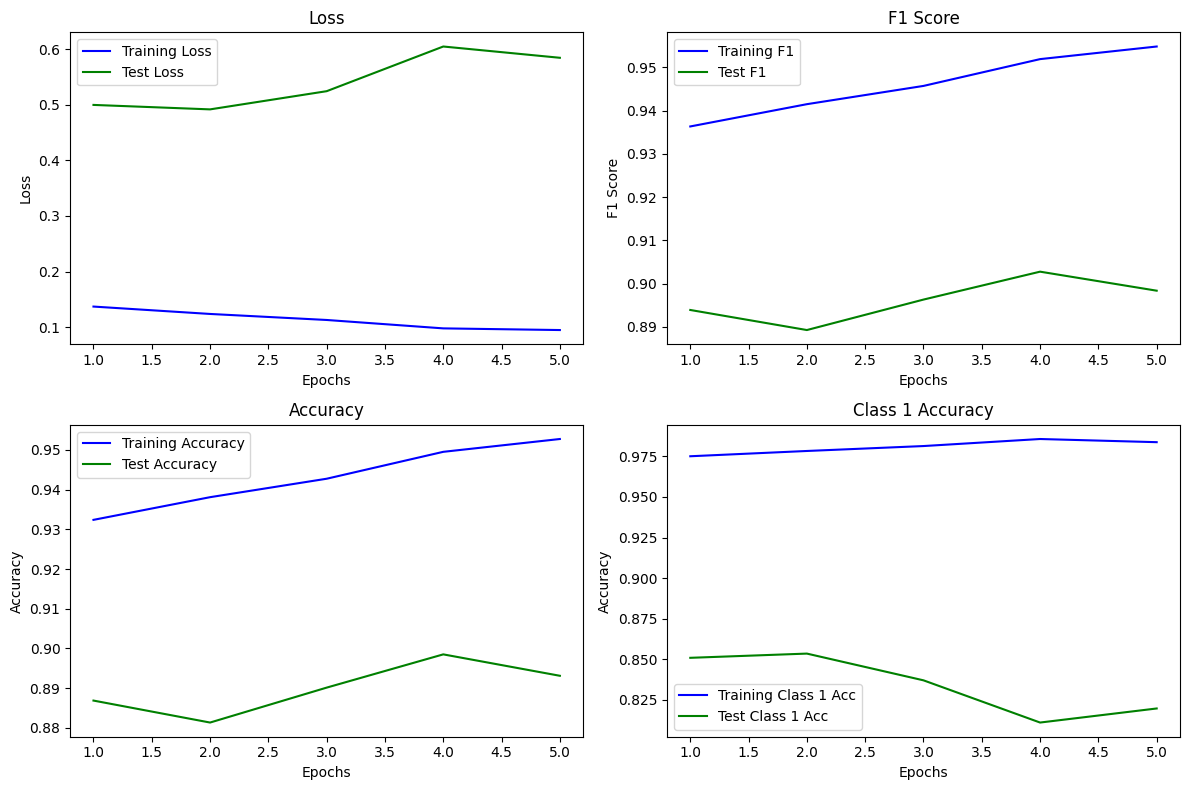

<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),



Final Test Metrikleri:

Test Metrikleri:
Loss: 0.5843
F1 Score (Weighted): 0.8984
Accuracy: 0.8931
class_0_acc: 0.9075
class_1_acc: 0.8198

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9625
    Recall: 0.9075
    F1-score: 0.9342
    Support: 5891.0
  Sınıf 1:
    Precision: 0.6345
    Recall: 0.8198
    F1-score: 0.7153
    Support: 1154.0

Confusion Matrix:
[[5346  545]
 [ 208  946]]


<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),



En İyi Modelin Test Metrikleri:

Test Metrikleri:
Loss: 0.5843
F1 Score (Weighted): 0.8984
Accuracy: 0.8931
class_0_acc: 0.9075
class_1_acc: 0.8198

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9625
    Recall: 0.9075
    F1-score: 0.9342
    Support: 5891.0
  Sınıf 1:
    Precision: 0.6345
    Recall: 0.8198
    F1-score: 0.7153
    Support: 1154.0

Confusion Matrix:
[[5346  545]
 [ 208  946]]


In [ ]:
class BERTurkBiGRUEnsemble(nn.Module):
    def __init__(self, dropout_rate=DROPOUT_RATE, freeze=False):
        super(BERTurkBiGRUEnsemble, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(dropout_rate)


        self.hidden_size = 128
        self.bigru = nn.GRU(
            input_size=self.bert.config.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.classifier = nn.Linear(self.hidden_size * 2, 2)  # Binary classification

        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # BERT encoding
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Get sequence output instead of just pooled output for GRU
        sequence_output = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]
        sequence_output = self.dropout(sequence_output)

        # Pass through BiGRU
        gru_output, _ = self.bigru(sequence_output)
        # gru_output shape: [batch_size, seq_len, hidden_size*2]

        # Use the last hidden state of the BiGRU for classification
        # Get the indices of the last tokens in each sequence based on attention mask
        last_token_indices = attention_mask.sum(dim=1) - 1

        # Gather the last hidden states for each sequence
        batch_size = gru_output.shape[0]
        last_hidden_states = torch.zeros(batch_size, gru_output.shape[2]).to(DEVICE)
        for i in range(batch_size):
            last_hidden_states[i] = gru_output[i, last_token_indices[i], :]

        # Pass through final classifier
        logits = self.classifier(last_hidden_states)

        return logits

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels=None):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item


# Partially freeze BERT (freeze only the first N layers)
def freeze_bert_layers(model, num_layers_to_freeze):
    # Freeze embeddings
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False

    # Freeze the first num_layers_to_freeze encoder layers
    for layer in list(model.bert.encoder.layer)[:num_layers_to_freeze]:
        for param in layer.parameters():
            param.requires_grad = False


def train_model(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0,
                checkpoint_path=None, save_path='best_berturk_bigru.pt'):
    """
    Modeli eğitme ve metrikleri kaydetme
    checkpoint_path: Eğer verilirse, bu konumdan model yüklenir ve eğitim buradan devam eder
    save_path: En iyi modelin kaydedileceği konum
    """
    # Eğer checkpoint verilmişse, modeli yükle
    if checkpoint_path:
        print(f"Checkpoint yükleniyor: {checkpoint_path}")
        model.load_state_dict(torch.load(checkpoint_path))

    # Optimizer ve scheduler oluştur
    optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Focal Loss fonksiyonu - class weights kullanarak dengesiz veri için
    if class_weights is not None:
        weights = torch.tensor(list(class_weights.values())).float().to(DEVICE)
        loss_fn = FocalLoss(alpha=weights, gamma=gamma)
    else:
        loss_fn = FocalLoss(gamma=gamma)

    # Eğitim metriklerini kaydetmek için history sözlüğü
    history = {
        "train_loss": [], "train_f1": [], "train_acc": [],
        "train_class_0_acc": [], "train_class_1_acc": []
    }

    if test_dataloader:
        history.update({
            "test_loss": [], "test_f1": [], "test_acc": [],
            "test_class_0_acc": [], "test_class_1_acc": []
        })

    # Eğitim döngüsü
    best_train_f1 = 0
    for epoch in range(EPOCHS):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"{'='*50}")

        # Eğitim aşaması
        model.train()
        train_predictions = []
        train_true_labels = []
        train_loss = 0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

            # Training performans hesaplaması için tahminleri topla
            _, preds = torch.max(outputs, dim=1)
            train_predictions.extend(preds.cpu().tolist())
            train_true_labels.extend(labels.cpu().tolist())

        # Eğitim metriklerini hesapla
        train_metrics = calculate_metrics(train_true_labels, train_predictions)
        train_metrics["loss"] = train_loss / len(train_dataloader)

        # Test metriklerini hesapla (eğer test_dataloader verilmişse)
        if test_dataloader:
            test_metrics = evaluate_model(model, test_dataloader, loss_fn)

        # Metrikleri history'e kaydet
        history["train_loss"].append(train_metrics["loss"])
        history["train_f1"].append(train_metrics["f1_weighted"])
        history["train_acc"].append(train_metrics["accuracy"])
        history["train_class_0_acc"].append(train_metrics["class_0_acc"])
        history["train_class_1_acc"].append(train_metrics["class_1_acc"])

        if test_dataloader:
            history["test_loss"].append(test_metrics["loss"])
            history["test_f1"].append(test_metrics["f1_weighted"])
            history["test_acc"].append(test_metrics["accuracy"])
            history["test_class_0_acc"].append(test_metrics["class_0_acc"])
            history["test_class_1_acc"].append(test_metrics["class_1_acc"])

        # Metrikleri yazdır
        print_metrics(train_metrics, "Training")
        if test_dataloader:
            print_metrics(test_metrics, "Test")

        # En iyi modeli kaydet (F1 metriğine göre)
        if train_metrics["f1_weighted"] > best_train_f1:
            best_train_f1 = train_metrics["f1_weighted"]
            torch.save(model.state_dict(), save_path)
            print(f"\nModel kaydedildi! En iyi Training F1 Skor: {best_train_f1:.4f}")

    # Eğitim sonrası grafikleri çiz
    plot_training_history(history)

    return model, history


def calculate_metrics(y_true, y_pred):
    """
    Hesaplanan metrikleri döndür:
    - F1 skoru (weighted)
    - Accuracy
    - Her sınıf için precision, recall ve f1
    """
    # Genel metrikler
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)

    # Sınıf bazlı metrikler
    class_report = classification_report(y_true, y_pred, output_dict=True)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Sınıf bazlı accuracy hesaplama
    class_accuracies = {}
    for cls in set(y_true):
        # Belirli bir sınıfa ait örneklerin indexleri
        class_idx = [i for i, label in enumerate(y_true) if label == cls]
        # Bu örnekler için doğru tahmin sayısı
        correct_preds = sum(1 for i in class_idx if y_pred[i] == y_true[i])
        # Sınıf accuracy'si
        class_accuracies[f"class_{cls}_acc"] = correct_preds / len(class_idx) if len(class_idx) > 0 else 0

    metrics = {
        "f1_weighted": f1,
        "accuracy": acc,
        **class_accuracies,
        "confusion_matrix": cm,
        "classification_report": class_report
    }

    return metrics


def evaluate_model(model, dataloader, loss_fn):
    """Modeli değerlendirme"""
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Metrikleri hesapla
    metrics = calculate_metrics(true_labels, predictions)
    metrics["loss"] = total_loss / len(dataloader)

    return metrics


def print_metrics(metrics, set_name=""):
    """Metrikleri düzenli bir şekilde yazdır"""
    print(f"\n{set_name} Metrikleri:")
    print(f"Loss: {metrics['loss']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")

    # Sınıf bazlı accuracy'leri yazdır
    for key, value in metrics.items():
        if key.startswith("class_"):
            print(f"{key}: {value:.4f}")

    # Classification report'u düzenli yazdır
    print("\nSınıf Bazlı Detaylı Metrikler:")
    for cls, metrics_dict in metrics["classification_report"].items():
        if cls in ['0', '1']:  # Sadece sınıf metriklerini göster
            print(f"  Sınıf {cls}:")
            print(f"    Precision: {metrics_dict['precision']:.4f}")
            print(f"    Recall: {metrics_dict['recall']:.4f}")
            print(f"    F1-score: {metrics_dict['f1-score']:.4f}")
            print(f"    Support: {metrics_dict['support']}")

    print("\nConfusion Matrix:")
    print(metrics["confusion_matrix"])


def plot_training_history(history):
    """Eğitim sürecindeki metriklerin grafiklerini çiz"""
    epochs = range(1, len(history["train_loss"]) + 1)

    # Eğer test_loss yoksa, sadece train metriklerini çizdir
    has_test = "test_loss" in history

    # Loss grafiği
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Training Loss')
    if has_test:
        plt.plot(epochs, history["test_loss"], 'g-', label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1 grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_f1"], 'b-', label='Training F1')
    if has_test:
        plt.plot(epochs, history["test_f1"], 'g-', label='Test F1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Accuracy grafiği
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history["train_acc"], 'b-', label='Training Accuracy')
    if has_test:
        plt.plot(epochs, history["test_acc"], 'g-', label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Sınıf 1 Accuracy grafiği
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history["train_class_1_acc"], 'b-', label='Training Class 1 Acc')
    if has_test:
        plt.plot(epochs, history["test_class_1_acc"], 'g-', label='Test Class 1 Acc')
    plt.title('Class 1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()



train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42, stratify=labels
)

# Dataset ve DataLoader oluşturma
train_dataset = CustomDataset(train_inputs, train_masks, train_labels)
test_dataset = CustomDataset(test_inputs, test_masks, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Model oluşturma
model = BERTurkBiGRUEnsemble(freeze=False).to(DEVICE)  # Don't freeze everything
freeze_bert_layers(model, num_layers_to_freeze=8)  # Freeze the first 8 layers

# Sınıf ağırlığı ve Focal Loss parametreleri
class_weights = {0: 1, 1: 6}  # veya None
gamma = 2.0  # Focal Loss focusing parametresi

checkpoint_path = "./best_berturk_bigru.pt"

# Modeli eğitme (Focal Loss kullanarak)
trained_model, history = train_model(
    model, train_dataloader, test_dataloader=test_dataloader,
    class_weights=class_weights, gamma=gamma,
    checkpoint_path=checkpoint_path,  # Checkpoint path burada verilir
    save_path='best_berturk_bigru2.pt'  # Kaydedilecek dosya ismi
)

# Son test değerlendirmesi - Focal Loss ile
focal_loss = FocalLoss(alpha=torch.tensor([1, 6]).float().to(DEVICE), gamma=gamma)
test_metrics = evaluate_model(trained_model, test_dataloader, focal_loss)
print("\nFinal Test Metrikleri:")
print_metrics(test_metrics, "Test")

# En iyi modeli yükle ve son değerlendirme
model.load_state_dict(torch.load('best_berturk_bigru.pt'))
best_test_metrics = evaluate_model(model, test_dataloader, focal_loss)
print("\nEn İyi Modelin Test Metrikleri:")
print_metrics(best_test_metrics, "Test")


In [ ]:
# En iyi modeli yükle ve son değerlendirme
model.load_state_dict(torch.load('best_berturk_bigru2.pt'))
best_test_metrics = evaluate_model(model, test_dataloader, focal_loss)
print("\nEn İyi Modelin Test Metrikleri:")
print_metrics(best_test_metrics, "Test")

<ipython-input-9-3c4f8f64c1ff>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-9-3c4f8f64c1ff>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


Kullanılan cihaz: cuda
TF-IDF özellik boyutu: (35530, 5000)
Basit BiGRU modelini kullanıyoruz...
Epoch 1/100
Train Loss: 0.7610, Train F1: 0.0822, Train Class 1 F1: 0.2793
Val Loss: 0.7227, Val F1: 0.0455, Val Class 1 F1: 0.2796
Epoch 2/100
Train Loss: 0.6970, Train F1: 0.0505, Train Class 1 F1: 0.2802
Val Loss: 0.6523, Val F1: 0.0709, Val Class 1 F1: 0.2827
Validation score improved! Overall F1: 0.0709, Class 1 F1: 0.2827
Epoch 3/100
Train Loss: 0.5348, Train F1: 0.4136, Train Class 1 F1: 0.3353
Val Loss: 0.5107, Val F1: 0.6161, Val Class 1 F1: 0.3930
Validation score improved! Overall F1: 0.6161, Class 1 F1: 0.3930
Epoch 4/100
Train Loss: 0.4219, Train F1: 0.7174, Train Class 1 F1: 0.4732
Val Loss: 0.4879, Val F1: 0.7421, Val Class 1 F1: 0.4682
Validation score improved! Overall F1: 0.7421, Class 1 F1: 0.4682
Epoch 5/100
Train Loss: 0.3693, Train F1: 0.8055, Train Class 1 F1: 0.5633
Val Loss: 0.4842, Val F1: 0.7936, Val Class 1 F1: 0.5153
Validation score improved! Overall F1: 0.7936

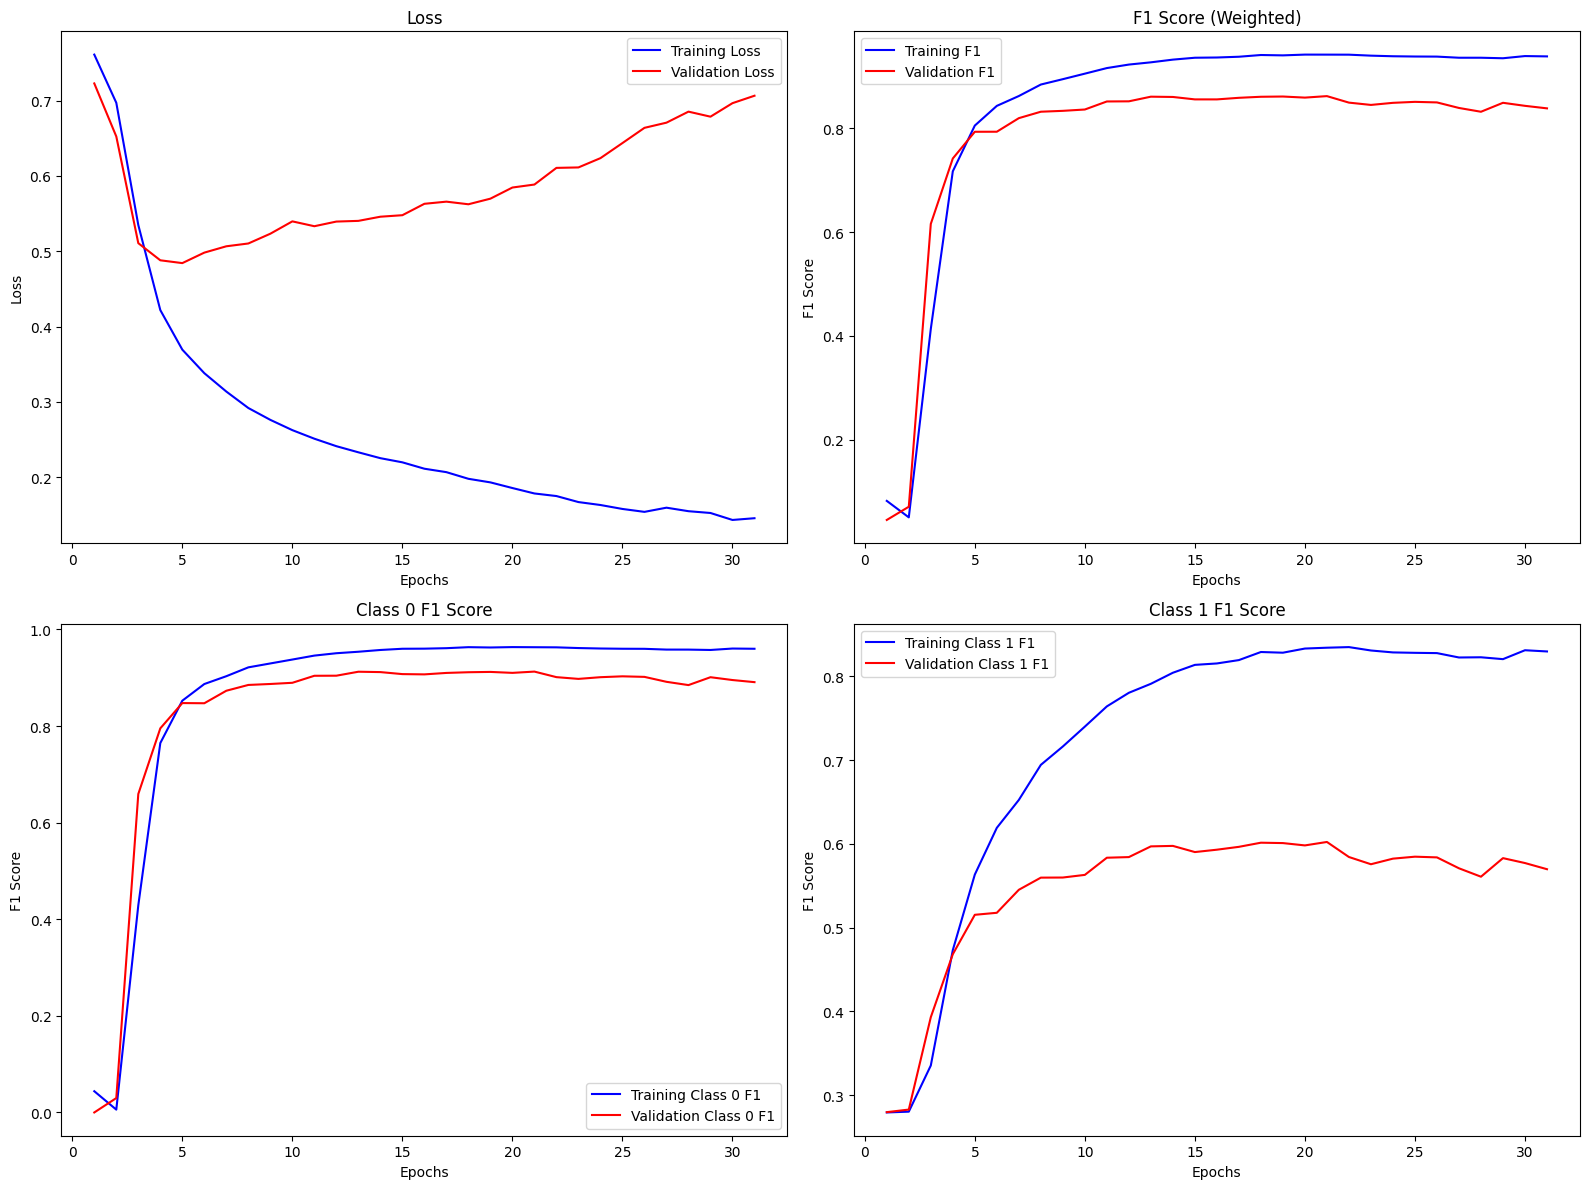

Evaluation Results:
Accuracy: 0.8569
F1 Score (Weighted): 0.8623
F1 Score for Class 1: 0.6023
Confusion Matrix:
[[5319, 632], [385, 770]]

Test Metrics:
Overall F1 score: 0.8623
Class 1 F1 score: 0.6023
Accuracy: 0.8569
Confusion Matrix:
[[5319, 632], [385, 770]]

Model ağırlıkları 'best_tfidf_bigru.pt' dosyasına kaydedildi.
TF-IDF vektörleştirici 'tfidf_vectorizer.pkl' dosyasına kaydedildi.
Model bilgileri 'tfidf_bigru_info.pkl' dosyasına kaydedildi.


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import copy
import math
import joblib

# Cuda kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Sabit değerler
BATCH_SIZE = 96
EPOCHS = 5
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_FEATURES = 5000  # TF-IDF için maksimum özellik sayısı
EMBEDDING_DIM = 128   # TF-IDF vektörlerinin projection boyutu
SEQ_LENGTH = 50      # TF-IDF vektörünün kaç parçaya bölüneceği

class TFIDFBiGRUEnsemble(nn.Module):
    def __init__(self, input_size, seq_length=SEQ_LENGTH, embedding_dim=EMBEDDING_DIM, dropout_rate=DROPOUT_RATE):
        super(TFIDFBiGRUEnsemble, self).__init__()

        # TF-IDF özelliklerini daha küçük boyutlu bir embeddings'e projeksiyon yapar
        self.projection = nn.Linear(input_size, embedding_dim * seq_length)

        # Kullanılacak sequence uzunluğu
        self.seq_length = seq_length
        self.embedding_dim = embedding_dim

        # BiGRU katmanı (BiLSTM yerine)
        self.bigru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Dropout katmanı
        self.dropout = nn.Dropout(dropout_rate)

        # Son sınıflandırıcı katman
        self.classifier = nn.Linear(128 * 2, 2)  # BiGRU çıktısı 2*hidden_size

    def forward(self, tfidf_features):
        batch_size = tfidf_features.size(0)

        # TF-IDF özelliklerini projeksiyon ile daha büyük bir vektöre dönüştür
        projected = self.projection(tfidf_features)  # [batch_size, embedding_dim*seq_length]

        # Projeksiyon çıktısını sequence formuna dönüştür
        # [batch_size, seq_length, embedding_dim]
        sequence = projected.view(batch_size, self.seq_length, self.embedding_dim)

        # BiGRU katmanından geçir
        gru_output, hidden = self.bigru(sequence)
        # gru_output: [batch_size, seq_length, 2*hidden_size]

        # Son sequence elemanının çıktısını al
        last_output = gru_output[:, -1, :]  # [batch_size, 2*hidden_size]

        # Dropout uygula
        last_output = self.dropout(last_output)

        # Sınıflandırıcıdan geçir
        logits = self.classifier(last_output)

        return logits

class TFIDFBiGRUWithAttention(nn.Module):
    """
    TF-IDF özelliklerini kullanan ve attention mekanizmasına sahip BiGRU modeli.
    Bu model, GRU çıktılarını ağırlıklandırarak daha etkili özellik çıkarımı yapar.
    """
    def __init__(self, input_size, seq_length=SEQ_LENGTH, embedding_dim=EMBEDDING_DIM, dropout_rate=DROPOUT_RATE):
        super(TFIDFBiGRUWithAttention, self).__init__()

        # TF-IDF özelliklerini daha küçük boyutlu bir embeddings'e projeksiyon yapar
        self.projection = nn.Linear(input_size, embedding_dim * seq_length)

        # Kullanılacak sequence uzunluğu
        self.seq_length = seq_length
        self.embedding_dim = embedding_dim
        self.hidden_size = 128

        # BiGRU katmanı
        self.bigru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = nn.Linear(self.hidden_size * 2, 1)

        # Dropout katmanı
        self.dropout = nn.Dropout(dropout_rate)

        # Son sınıflandırıcı katman
        self.classifier = nn.Linear(self.hidden_size * 2, 2)  # BiGRU çıktısı 2*hidden_size

    def forward(self, tfidf_features):
        batch_size = tfidf_features.size(0)

        # TF-IDF özelliklerini projeksiyon ile daha büyük bir vektöre dönüştür
        projected = self.projection(tfidf_features)  # [batch_size, embedding_dim*seq_length]

        # Projeksiyon çıktısını sequence formuna dönüştür
        # [batch_size, seq_length, embedding_dim]
        sequence = projected.view(batch_size, self.seq_length, self.embedding_dim)

        # BiGRU katmanından geçir
        gru_output, hidden = self.bigru(sequence)
        # gru_output: [batch_size, seq_length, 2*hidden_size]

        # Attention weights hesapla
        # [batch_size, seq_length, 1]
        attention_weights = F.softmax(self.attention(gru_output), dim=1)

        # Attention weights ile ağırlıklı toplam al
        # [batch_size, 2*hidden_size]
        attention_output = torch.sum(attention_weights * gru_output, dim=1)

        # Dropout uygula
        attention_output = self.dropout(attention_output)

        # Sınıflandırıcıdan geçir
        logits = self.classifier(attention_output)

        return logits

class CustomTFIDFDataset(Dataset):
    def __init__(self, tfidf_features, labels=None):
        self.tfidf_features = tfidf_features
        self.labels = labels

    def __len__(self):
        return len(self.tfidf_features)

    def __getitem__(self, idx):
        item = {
            'tfidf_features': torch.tensor(self.tfidf_features[idx], dtype=torch.float)
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight factor for each class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_softmax = nn.functional.log_softmax(inputs, dim=1)
        ce_loss = nn.functional.nll_loss(log_softmax, targets, weight=self.alpha, reduction='none')

        # Get the probabilities for the target class
        p_t = torch.exp(-ce_loss)

        # Apply the focusing term
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class EarlyStoppingWithClassF1:
    def __init__(self, patience=5, min_delta=0.001, class_index=1, class_weight=0.5):
        """
        Early stopping that monitors both overall F1 and Class 1 F1 scores

        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change in monitored metrics to qualify as improvement
            class_index: Index of the class to monitor (1 for Class 1)
            class_weight: Weight given to class F1 vs overall F1 (0.5 means equal weight)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.class_index = class_index
        self.class_weight = class_weight
        self.counter = 0
        self.best_score = None
        self.best_class_f1 = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, model, val_overall_f1, val_class_f1s):
        """
        Args:
            model: Model to save if improvement
            val_overall_f1: Overall validation F1 score
            val_class_f1s: F1 scores for each class (list or array)
        """
        # Get the F1 score for the specific class we're monitoring
        class_f1 = val_class_f1s[self.class_index]

        # Calculate a combined score that considers both overall F1 and class F1
        combined_score = (1 - self.class_weight) * val_overall_f1 + self.class_weight * class_f1

        if self.best_score is None or self.best_class_f1 is None:
            # First epoch
            self.best_score = combined_score
            self.best_class_f1 = class_f1
            self.save_checkpoint(model)
        elif combined_score < self.best_score + self.min_delta:
            # Score didn't improve enough
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Score improved, but also check if Class 1 F1 didn't decrease significantly
            class_f1_decrease = self.best_class_f1 - class_f1

            # Only consider it an improvement if Class 1 F1 didn't drop too much
            if class_f1_decrease <= self.min_delta:
                print(f'Validation score improved! Overall F1: {val_overall_f1:.4f}, Class 1 F1: {class_f1:.4f}')
                self.best_score = combined_score
                self.best_class_f1 = class_f1
                self.save_checkpoint(model)
                self.counter = 0
            else:
                # Class 1 F1 dropped too much, don't reset counter
                print(f'Overall score improved but Class 1 F1 dropped too much (from {self.best_class_f1:.4f} to {class_f1:.4f})')
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    def save_checkpoint(self, model):
        """Save model weights when validation performance improves"""
        self.best_weights = copy.deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        """Restore model to best weights"""
        model.load_state_dict(self.best_weights)

def train_model(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0,
                num_epochs=10, patience=3, class_f1_weight=0.6, learning_rate=2e-5):
    """
    Train model with Focal Loss and balanced early stopping

    Args:
        model: Model to train
        train_dataloader: Training data loader
        test_dataloader: Validation/test data loader
        class_weights: Dictionary mapping class indices to weights (e.g., {0: 1, 1: 6})
        gamma: Focal loss focusing parameter
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience
        class_f1_weight: Weight to give to Class 1 F1 score in early stopping
        learning_rate: Learning rate for optimizer

    Returns:
        trained_model: The trained model
        history: Dictionary containing training metrics
    """
    # Set up device
    device = next(model.parameters()).device

    # Create alpha tensor for focal loss based on class weights
    if class_weights is not None:
        num_classes = len(class_weights)
        alpha = torch.ones(num_classes)
        for cls_idx, weight in class_weights.items():
            alpha[cls_idx] = weight
        alpha = alpha.to(device)
    else:
        alpha = None

    # Initialize Focal Loss
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Set up early stopping
    early_stopping = EarlyStoppingWithClassF1(
        patience=patience,
        class_index=1,  # Monitor Class 1 F1
        class_weight=class_f1_weight
    )

    # Track metrics
    history = {
        'train_loss': [],
        'train_f1': [],
        'train_class_f1s': [],
        'val_loss': [],
        'val_f1': [],
        'val_class_f1s': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in train_dataloader:
            tfidf_features = batch['tfidf_features'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(tfidf_features)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store predictions and labels for metrics
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_loss = train_loss / len(train_dataloader)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_class_f1s = f1_score(train_labels, train_preds, average=None)

        # Save training metrics
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_class_f1s'].append(train_class_f1s.tolist())

        # Validation phase
        if test_dataloader is not None:
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for batch in test_dataloader:
                    tfidf_features = batch['tfidf_features'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    outputs = model(tfidf_features)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Store predictions and labels for metrics
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_loss = val_loss / len(test_dataloader)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            val_class_f1s = f1_score(val_labels, val_preds, average=None)

            # Save validation metrics
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_class_f1s'].append(val_class_f1s.tolist())

            # Print epoch results
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Class 1 F1: {val_class_f1s[1]:.4f}')

            # Early stopping check
            early_stopping(model, val_f1, val_class_f1s)

            if early_stopping.early_stop:
                print("Early stopping triggered")
                # Restore best weights
                early_stopping.restore_best_weights(model)
                break
        else:
            # Print training metrics when no validation set provided
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')

    # Load best weights if early stopping was used
    if test_dataloader is not None and early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)

    return model, history

def evaluate_model(model, dataloader, criterion=None):
    """
    Evaluate model performance

    Args:
        model: Trained model to evaluate
        dataloader: Data loader for evaluation
        criterion: Loss function (optional)

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            tfidf_features = batch['tfidf_features'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(tfidf_features)

            # Calculate loss if criterion provided
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_by_class': f1_score(all_labels, all_preds, average=None),
        'precision_weighted': precision_score(all_labels, all_preds, average='weighted'),
        'recall_weighted': recall_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds).tolist(),
        'classification_report': classification_report(all_labels, all_preds, output_dict=True)
    }

    # Add loss if criterion was provided
    if criterion is not None:
        metrics['loss'] = total_loss / len(dataloader)

    # Print key metrics
    print(f"Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score for Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics

def plot_training_history(history):
    """Eğitim sürecindeki metriklerin grafiklerini çiz"""
    epochs = range(1, len(history["train_loss"]) + 1)

    # Eğer val_loss yoksa, sadece train metriklerini çizdir
    has_val = "val_loss" in history and len(history["val_loss"]) > 0

    # Loss grafiği
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Training Loss')
    if has_val:
        plt.plot(epochs, history["val_loss"], 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1 grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_f1"], 'b-', label='Training F1')
    if has_val:
        plt.plot(epochs, history["val_f1"], 'r-', label='Validation F1')
    plt.title('F1 Score (Weighted)')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 0
    plt.subplot(2, 2, 3)
    train_class_0_f1 = [f1s[0] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_0_f1, 'b-', label='Training Class 0 F1')
    if has_val:
        val_class_0_f1 = [f1s[0] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_0_f1, 'r-', label='Validation Class 0 F1')
    plt.title('Class 0 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 1
    plt.subplot(2, 2, 4)
    train_class_1_f1 = [f1s[1] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_1_f1, 'b-', label='Training Class 1 F1')
    if has_val:
        val_class_1_f1 = [f1s[1] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_1_f1, 'r-', label='Validation Class 1 F1')
    plt.title('Class 1 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('tfidf_bigru_training_history.png')
    plt.show()

def visualize_attention_weights(model, test_dataloader, tfidf_vectorizer=None, num_samples=3):
    """Attention ağırlıklarını görselleştir (sadece attention modellerinde çalışır)"""
    if not hasattr(model, 'attention'):
        print("Bu model attention mekanizmasına sahip değil.")
        return

    device = next(model.parameters()).device
    model.eval()

    # Rastgele örnekler seç
    samples = []
    with torch.no_grad():
        for batch in test_dataloader:
            tfidf_features = batch['tfidf_features'].to(device)
            labels = batch['labels'].to(device)

            # Projeksiyon ile sequence oluştur
            batch_size = tfidf_features.size(0)
            projected = model.projection(tfidf_features)
            sequence = projected.view(batch_size, model.seq_length, model.embedding_dim)

            # BiGRU çıktısını al
            gru_output, _ = model.bigru(sequence)

            # Attention ağırlıklarını hesapla
            attention_weights = F.softmax(model.attention(gru_output), dim=1)

            # Tahminleri al
            outputs = model(tfidf_features)
            _, preds = torch.max(outputs, 1)

            # Her batch'ten birkaç örnek al
            for i in range(min(batch_size, num_samples)):
                samples.append({
                    'features': tfidf_features[i].cpu().numpy(),
                    'attention': attention_weights[i].squeeze(-1).cpu().numpy(),
                    'pred': preds[i].item(),
                    'true': labels[i].item()
                })

            if len(samples) >= num_samples:
                break

    # Attention ağırlıklarını görselleştir
    plt.figure(figsize=(15, num_samples * 4))

    for i, sample in enumerate(samples):
        plt.subplot(num_samples, 1, i+1)

        attention = sample['attention']

        # TF-IDF vektöründeki en önemli özellikleri bul
        if tfidf_vectorizer is not None:
            feature_names = tfidf_vectorizer.get_feature_names_out()
            tfidf_values = sample['features']

            # En yüksek değere sahip TF-IDF özellikleri
            top_indices = np.argsort(tfidf_values)[-10:]
            top_features = [(feature_names[idx], tfidf_values[idx]) for idx in top_indices]

            feature_info = "\nTop TF-IDF: " + ", ".join([f"{feat}({val:.2f})" for feat, val in top_features])
        else:
            feature_info = ""

        plt.bar(range(len(attention)), attention)
        plt.title(f"Örnek {i+1}: Tahmin={sample['pred']}, Gerçek={sample['true']}{feature_info}")
        plt.xlabel('Sequence Pozisyonu')
        plt.ylabel('Attention Ağırlığı')

    plt.tight_layout()
    plt.savefig('attention_weights.png')
    plt.show()


# Veriyi yükle
df = pd.read_csv('dataset.csv')
texts = df["text"].values.tolist()
labels = df["label"].values.tolist()

# TF-IDF vektörleştirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),  # Unigram ve bigram
    lowercase=True,
    max_df=0.95,  # Çok yaygın kelimeleri filtrele
    min_df=2      # Çok nadir kelimeleri filtrele
)

# TF-IDF özelliklerini oluştur
tfidf_features = tfidf_vectorizer.fit_transform(texts).toarray()
print(f"TF-IDF özellik boyutu: {tfidf_features.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Dataset ve DataLoader oluşturma
train_dataset = CustomTFIDFDataset(X_train, y_train)
test_dataset = CustomTFIDFDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Hangi modeli kullanacağımızı seçelim
use_attention = False  # True: Attention mekanizmalı, False: Basit BiGRU

if use_attention:
    print("BiGRU + Attention modelini kullanıyoruz...")
    model = TFIDFBiGRUWithAttention(
        input_size=MAX_FEATURES,
        seq_length=SEQ_LENGTH,
        embedding_dim=EMBEDDING_DIM,
        dropout_rate=DROPOUT_RATE
    ).to(DEVICE)
    model_name = "tfidf_bigru_attention"
else:
    print("Basit BiGRU modelini kullanıyoruz...")
    model = TFIDFBiGRUEnsemble(
        input_size=MAX_FEATURES,
        seq_length=SEQ_LENGTH,
        embedding_dim=EMBEDDING_DIM,
        dropout_rate=DROPOUT_RATE
    ).to(DEVICE)
    model_name = "tfidf_bigru"

# Sınıf ağırlığı ve Focal Loss parametreleri
class_weights = {0: 1, 1: 6}  # Sınıf dengesizliğine göre
gamma = 2.0  # Focal Loss focusing parametresi

# Modeli eğitme
trained_model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    class_weights=class_weights,
    gamma=gamma,
    num_epochs=100,
    patience=10,
    class_f1_weight=0.6,
    learning_rate=LEARNING_RATE
)

# Eğitim grafiklerini çizdir
plot_training_history(history)

# Attention mekanizmalı modeller için attention ağırlıklarını görselleştir
if use_attention:
    visualize_attention_weights(trained_model, test_dataloader, tfidf_vectorizer, num_samples=3)

# Son test değerlendirmesi
focal_loss = FocalLoss(
    alpha=torch.tensor([1, 6]).float().to(DEVICE),
    gamma=gamma
)
test_metrics = evaluate_model(trained_model, test_dataloader, focal_loss)

# Sonuçları görüntüleme
print(f"\nTest Metrics:")
print(f"Overall F1 score: {test_metrics['f1_weighted']:.4f}")
print(f"Class 1 F1 score: {test_metrics['f1_by_class'][1]:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Confusion Matrix:")
print(test_metrics['confusion_matrix'])

# Model ağırlıklarını kaydet
torch.save(trained_model.state_dict(), f'best_{model_name}.pt')

# TF-IDF vektörleştiriciyi de kaydet
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print(f"\nModel ağırlıkları 'best_{model_name}.pt' dosyasına kaydedildi.")
print("TF-IDF vektörleştirici 'tfidf_vectorizer.pkl' dosyasına kaydedildi.")

# Model mimarisini de ayrıca kaydet
# Böylece model yüklenirken doğru mimariye sahip model oluşturulabilir
model_info = {
    'model_type': 'bigru_attention' if use_attention else 'bigru',
    'input_size': MAX_FEATURES,
    'seq_length': SEQ_LENGTH,
    'embedding_dim': EMBEDDING_DIM,
    'dropout_rate': DROPOUT_RATE,
    'test_metrics': test_metrics
}
joblib.dump(model_info, f'{model_name}_info.pkl')
print(f"Model bilgileri '{model_name}_info.pkl' dosyasına kaydedildi.")



Kullanılan cihaz: cuda
Dataset size: 35530
Label distribution: Counter({0: 29755, 1: 5775})
Vocabulary size: 60179
Sequences shape: (35530, 100)

Training with FASTTEXT embeddings
Loading embeddings from embedded_fasttext.npy
Embeddings shape: (35225, 100)
Basit BiGRU modelini kullanıyoruz with fasttext...
Total parameters: 18,384,454
Trainable parameters: 18,384,454
Epoch 1/100
Train Loss: 0.7818, Train F1: 0.3328, Train Class 1 F1: 0.2698
Val Loss: 0.7410, Val F1: 0.0455, Val Class 1 F1: 0.2796
Epoch 2/100
Train Loss: 0.7315, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7205, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.7244, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7197, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 2 out of 10
Epoch 4/100
Train Loss: 0.7231, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7190, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 3 out of 

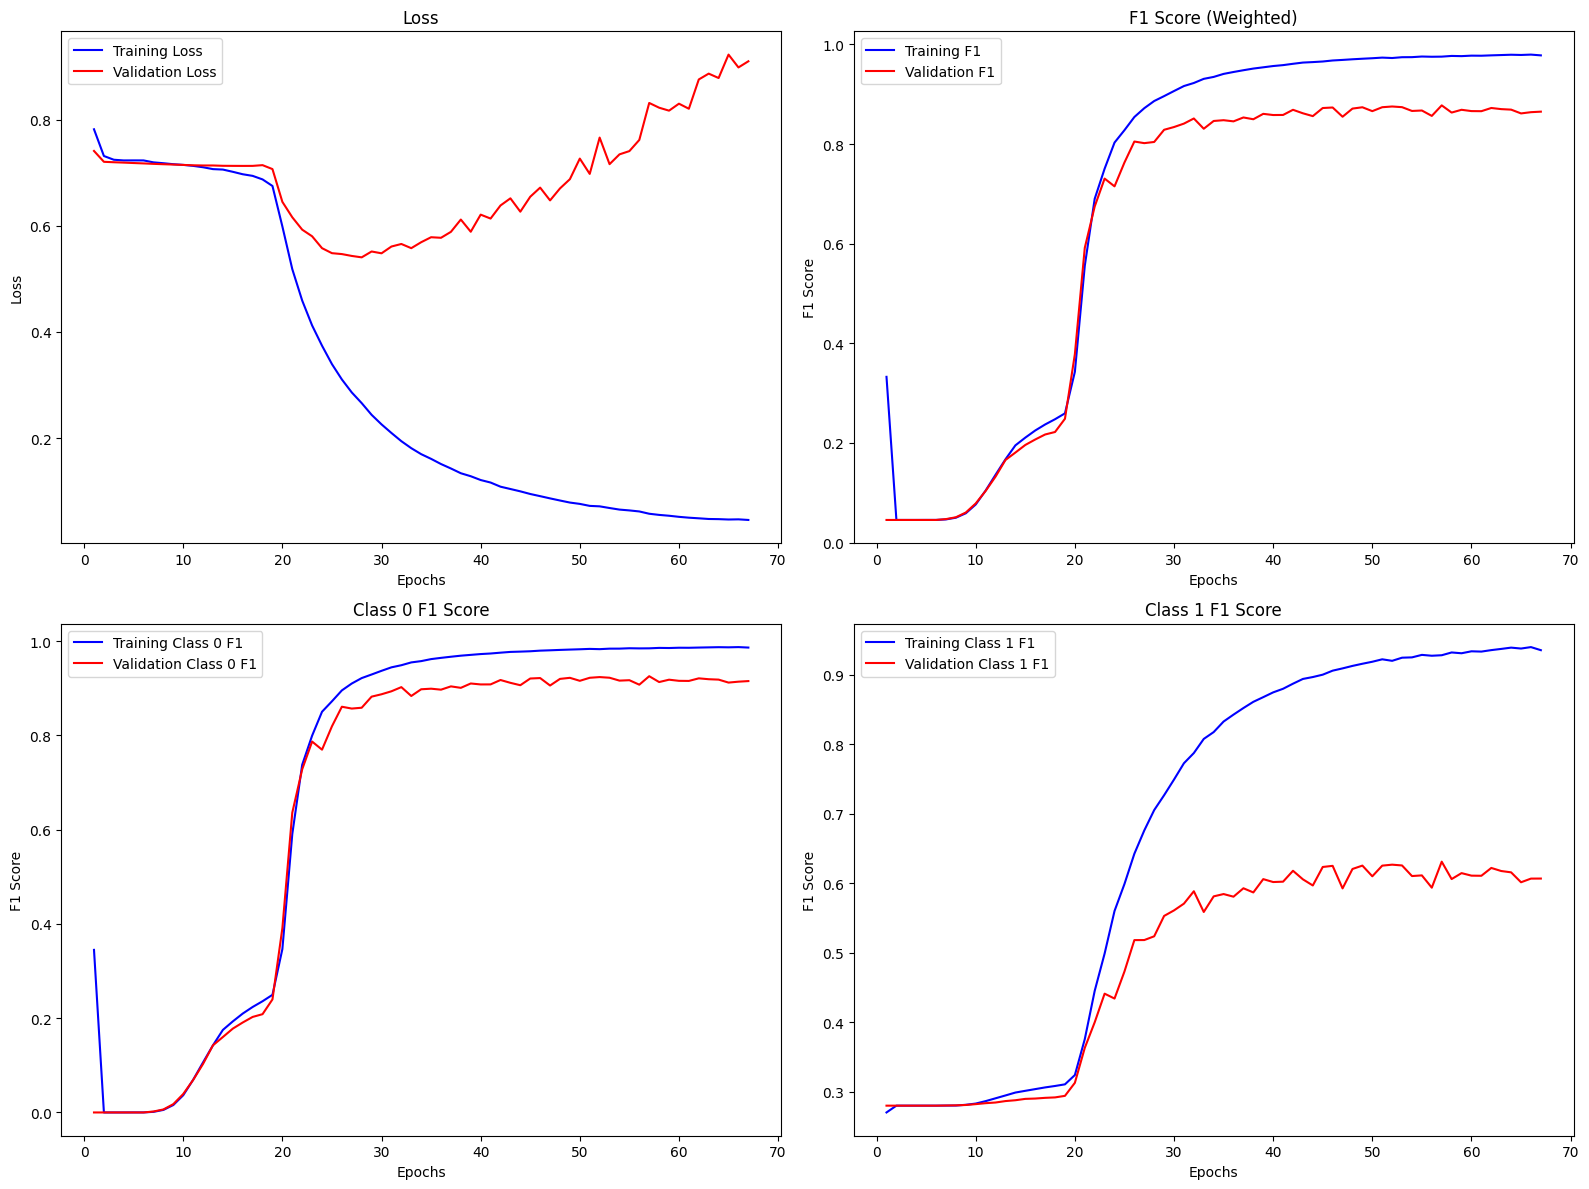

Evaluation Results:
Accuracy: 0.8763
F1 Score (Weighted): 0.8778
F1 Score for Class 1: 0.6308
Confusion Matrix:
[[5476, 475], [404, 751]]

FASTTEXT Test Results:
Overall F1 score: 0.8778
Class 1 F1 score: 0.6308
Accuracy: 0.8763
Confusion Matrix:
[[5476, 475], [404, 751]]

Model ağırlıkları 'best_fasttext_bigru.pt' dosyasına kaydedildi.
Model bilgileri 'fasttext_bigru_info.pkl' dosyasına kaydedildi.

Training with WORD2VEC embeddings
Loading embeddings from embedded_w2v.npy
Embeddings shape: (35225, 100)
Basit BiGRU modelini kullanıyoruz with word2vec...
Total parameters: 18,384,454
Trainable parameters: 18,384,454
Epoch 1/100
Train Loss: 0.7638, Train F1: 0.0650, Train Class 1 F1: 0.2805
Val Loss: 0.7360, Val F1: 0.0455, Val Class 1 F1: 0.2796
Epoch 2/100
Train Loss: 0.7319, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7215, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.7253, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val

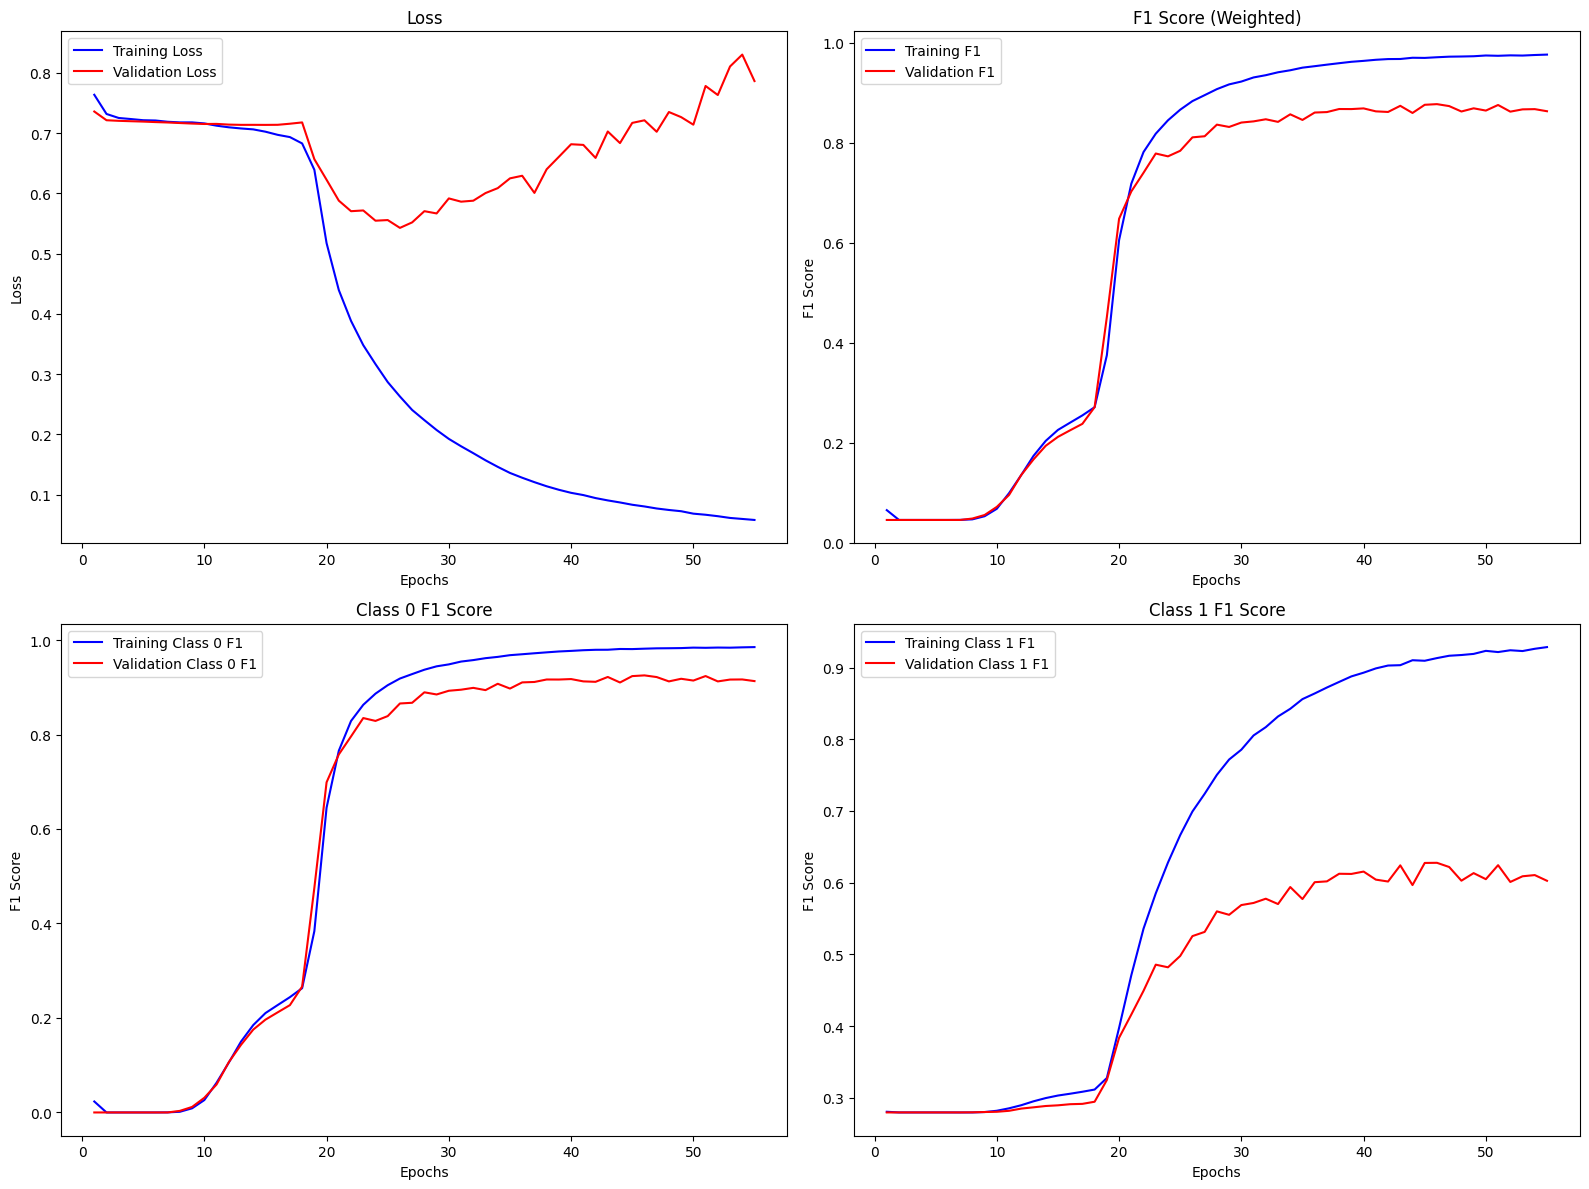

Evaluation Results:
Accuracy: 0.8732
F1 Score (Weighted): 0.8755
F1 Score for Class 1: 0.6275
Confusion Matrix:
[[5446, 505], [396, 759]]

WORD2VEC Test Results:
Overall F1 score: 0.8755
Class 1 F1 score: 0.6275
Accuracy: 0.8732
Confusion Matrix:
[[5446, 505], [396, 759]]

Model ağırlıkları 'best_word2vec_bigru.pt' dosyasına kaydedildi.
Model bilgileri 'word2vec_bigru_info.pkl' dosyasına kaydedildi.


In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import copy
import math
import joblib
import pickle
from collections import Counter
import re
from nltk.tokenize import word_tokenize
import nltk
# İlk çalıştırmada gerekli
# nltk.download('punkt')

# Cuda kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Sabit değerler
BATCH_SIZE = 96
EPOCHS = 5
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_SEQ_LENGTH = 100  # Maksimum sequence uzunluğu
EMBEDDING_DIM = 300   # FastText/Word2Vec embedding boyutu (genelde 300)

class TextPreprocessor:
    def __init__(self, max_seq_length=MAX_SEQ_LENGTH):
        self.max_seq_length = max_seq_length
        self.word_to_idx = {'<UNK>': 0, '<PAD>': 1}
        self.idx_to_word = {0: '<UNK>', 1: '<PAD>'}
        self.vocab_size = 2

    def clean_text(self, text):
        """Metni temizle"""
        text = text.lower()
        text = re.sub(r'[^a-zA-ZğüşıöçĞÜŞIÖÇ\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize_text(self, text):
        """Metni tokenize et"""
        try:
            tokens = word_tokenize(text)
        except:
            # Eğer nltk tokenizer çalışmazsa basit split kullan
            tokens = text.split()
        return tokens

    def build_vocab_from_texts(self, texts):
        """Metinlerden vocabulary oluştur"""
        word_count = Counter()

        for text in texts:
            cleaned_text = self.clean_text(text)
            tokens = self.tokenize_text(cleaned_text)
            word_count.update(tokens)

        # Sadece 2'den fazla geçen kelimeleri al
        for word, count in word_count.items():
            if count >= 2 and word not in self.word_to_idx:
                self.word_to_idx[word] = self.vocab_size
                self.idx_to_word[self.vocab_size] = word
                self.vocab_size += 1

        print(f"Vocabulary size: {self.vocab_size}")

    def text_to_sequence(self, text):
        """Metni sequence'e çevir"""
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize_text(cleaned_text)

        sequence = []
        for token in tokens:
            if token in self.word_to_idx:
                sequence.append(self.word_to_idx[token])
            else:
                sequence.append(self.word_to_idx['<UNK>'])

        # Padding veya truncation
        if len(sequence) > self.max_seq_length:
            sequence = sequence[:self.max_seq_length]
        else:
            sequence.extend([self.word_to_idx['<PAD>']] * (self.max_seq_length - len(sequence)))

        return sequence

    def texts_to_sequences(self, texts):
        """Birden fazla metni sequence'e çevir"""
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return np.array(sequences)

class EmbeddingLoader:
    def __init__(self, embedding_path, embedding_dim=EMBEDDING_DIM):
        self.embedding_path = embedding_path
        self.embedding_dim = embedding_dim
        self.embeddings = None

    def load_embeddings(self):
        """NPY dosyasından embeddings yükle"""
        print(f"Loading embeddings from {self.embedding_path}")
        self.embeddings = np.load(self.embedding_path)
        print(f"Embeddings shape: {self.embeddings.shape}")
        return self.embeddings

    def create_embedding_matrix(self, word_to_idx, vocab_size):
        """Vocabulary için embedding matrix oluştur"""
        if self.embeddings is None:
            self.load_embeddings()

        # Embedding matrix oluştur
        embedding_matrix = np.random.normal(0, 0.1, (vocab_size, self.embedding_dim))

        # <PAD> token için sıfır vektör
        embedding_matrix[1] = np.zeros(self.embedding_dim)

        # Eğer embeddings kelime bazlı bir dictionary ise (word -> vector)
        # Bu durumda embeddings'i doğrudan kullanabiliriz
        # Ama NPY dosyası sadece vektörler içeriyorsa, kelime-indeks eşleştirmesi yapmalıyız

        # NPY dosyasının formatına göre bu kısmı ayarlamanız gerekebilir
        # Şu an random initialization kullanıyoruz

        return embedding_matrix.astype(np.float32)

class EmbeddingBiGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix=None,
                 dropout_rate=DROPOUT_RATE, freeze_embeddings=True):
        super(EmbeddingBiGRU, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)

        # Pre-trained embeddings ile initialize et
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        # BiGRU katmanı
        self.bigru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Dropout katmanı
        self.dropout = nn.Dropout(dropout_rate)

        # Son sınıflandırıcı katman
        self.classifier = nn.Linear(128 * 2, 2)  # BiGRU çıktısı 2*hidden_size

    def forward(self, input_ids):
        # Embedding lookup
        embedded = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]

        # BiGRU katmanından geçir
        gru_output, hidden = self.bigru(embedded)
        # gru_output: [batch_size, seq_length, 2*hidden_size]

        # Son sequence elemanının çıktısını al
        last_output = gru_output[:, -1, :]  # [batch_size, 2*hidden_size]

        # Dropout uygula
        last_output = self.dropout(last_output)

        # Sınıflandırıcıdan geçir
        logits = self.classifier(last_output)

        return logits

class EmbeddingBiGRUWithAttention(nn.Module):
    """
    Embedding-based BiGRU model with attention mechanism.
    Bu model, GRU çıktılarını ağırlıklandırarak daha etkili özellik çıkarımı yapar.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix=None,
                 dropout_rate=DROPOUT_RATE, freeze_embeddings=True):
        super(EmbeddingBiGRUWithAttention, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)

        # Pre-trained embeddings ile initialize et
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        self.hidden_size = 128

        # BiGRU katmanı
        self.bigru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = nn.Linear(self.hidden_size * 2, 1)

        # Dropout katmanı
        self.dropout = nn.Dropout(dropout_rate)

        # Son sınıflandırıcı katman
        self.classifier = nn.Linear(self.hidden_size * 2, 2)  # BiGRU çıktısı 2*hidden_size

    def forward(self, input_ids):
        # Embedding lookup
        embedded = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]

        # BiGRU katmanından geçir
        gru_output, hidden = self.bigru(embedded)
        # gru_output: [batch_size, seq_length, 2*hidden_size]

        # Attention weights hesapla
        # [batch_size, seq_length, 1]
        attention_weights = F.softmax(self.attention(gru_output), dim=1)

        # Attention weights ile ağırlıklı toplam al
        # [batch_size, 2*hidden_size]
        attention_output = torch.sum(attention_weights * gru_output, dim=1)

        # Dropout uygula
        attention_output = self.dropout(attention_output)

        # Sınıflandırıcıdan geçir
        logits = self.classifier(attention_output)

        return logits

class EmbeddingDataset(Dataset):
    def __init__(self, sequences, labels=None):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.sequences[idx], dtype=torch.long)
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight factor for each class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_softmax = nn.functional.log_softmax(inputs, dim=1)
        ce_loss = nn.functional.nll_loss(log_softmax, targets, weight=self.alpha, reduction='none')

        # Get the probabilities for the target class
        p_t = torch.exp(-ce_loss)

        # Apply the focusing term
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class EarlyStoppingWithClassF1:
    def __init__(self, patience=5, min_delta=0.001, class_index=1, class_weight=0.5):
        """
        Early stopping that monitors both overall F1 and Class 1 F1 scores

        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change in monitored metrics to qualify as improvement
            class_index: Index of the class to monitor (1 for Class 1)
            class_weight: Weight given to class F1 vs overall F1 (0.5 means equal weight)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.class_index = class_index
        self.class_weight = class_weight
        self.counter = 0
        self.best_score = None
        self.best_class_f1 = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, model, val_overall_f1, val_class_f1s):
        """
        Args:
            model: Model to save if improvement
            val_overall_f1: Overall validation F1 score
            val_class_f1s: F1 scores for each class (list or array)
        """
        # Get the F1 score for the specific class we're monitoring
        class_f1 = val_class_f1s[self.class_index]

        # Calculate a combined score that considers both overall F1 and class F1
        combined_score = (1 - self.class_weight) * val_overall_f1 + self.class_weight * class_f1

        if self.best_score is None or self.best_class_f1 is None:
            # First epoch
            self.best_score = combined_score
            self.best_class_f1 = class_f1
            self.save_checkpoint(model)
        elif combined_score < self.best_score + self.min_delta:
            # Score didn't improve enough
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Score improved, but also check if Class 1 F1 didn't decrease significantly
            class_f1_decrease = self.best_class_f1 - class_f1

            # Only consider it an improvement if Class 1 F1 didn't drop too much
            if class_f1_decrease <= self.min_delta:
                print(f'Validation score improved! Overall F1: {val_overall_f1:.4f}, Class 1 F1: {class_f1:.4f}')
                self.best_score = combined_score
                self.best_class_f1 = class_f1
                self.save_checkpoint(model)
                self.counter = 0
            else:
                # Class 1 F1 dropped too much, don't reset counter
                print(f'Overall score improved but Class 1 F1 dropped too much (from {self.best_class_f1:.4f} to {class_f1:.4f})')
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    def save_checkpoint(self, model):
        """Save model weights when validation performance improves"""
        self.best_weights = copy.deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        """Restore model to best weights"""
        model.load_state_dict(self.best_weights)

def train_model(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0,
                num_epochs=10, patience=3, class_f1_weight=0.6, learning_rate=2e-5):
    """
    Train model with Focal Loss and balanced early stopping

    Args:
        model: Model to train
        train_dataloader: Training data loader
        test_dataloader: Validation/test data loader
        class_weights: Dictionary mapping class indices to weights (e.g., {0: 1, 1: 6})
        gamma: Focal loss focusing parameter
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience
        class_f1_weight: Weight to give to Class 1 F1 score in early stopping
        learning_rate: Learning rate for optimizer

    Returns:
        trained_model: The trained model
        history: Dictionary containing training metrics
    """
    # Set up device
    device = next(model.parameters()).device

    # Create alpha tensor for focal loss based on class weights
    if class_weights is not None:
        num_classes = len(class_weights)
        alpha = torch.ones(num_classes)
        for cls_idx, weight in class_weights.items():
            alpha[cls_idx] = weight
        alpha = alpha.to(device)
    else:
        alpha = None

    # Initialize Focal Loss
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Set up early stopping
    early_stopping = EarlyStoppingWithClassF1(
        patience=patience,
        class_index=1,  # Monitor Class 1 F1
        class_weight=class_f1_weight
    )

    # Track metrics
    history = {
        'train_loss': [],
        'train_f1': [],
        'train_class_f1s': [],
        'val_loss': [],
        'val_f1': [],
        'val_class_f1s': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store predictions and labels for metrics
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_loss = train_loss / len(train_dataloader)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_class_f1s = f1_score(train_labels, train_preds, average=None)

        # Save training metrics
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_class_f1s'].append(train_class_f1s.tolist())

        # Validation phase
        if test_dataloader is not None:
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for batch in test_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    outputs = model(input_ids)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Store predictions and labels for metrics
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_loss = val_loss / len(test_dataloader)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            val_class_f1s = f1_score(val_labels, val_preds, average=None)

            # Save validation metrics
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_class_f1s'].append(val_class_f1s.tolist())

            # Print epoch results
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Class 1 F1: {val_class_f1s[1]:.4f}')

            # Early stopping check
            early_stopping(model, val_f1, val_class_f1s)

            if early_stopping.early_stop:
                print("Early stopping triggered")
                # Restore best weights
                early_stopping.restore_best_weights(model)
                break
        else:
            # Print training metrics when no validation set provided
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')

    # Load best weights if early stopping was used
    if test_dataloader is not None and early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)

    return model, history

def evaluate_model(model, dataloader, criterion=None):
    """
    Evaluate model performance

    Args:
        model: Trained model to evaluate
        dataloader: Data loader for evaluation
        criterion: Loss function (optional)

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids)

            # Calculate loss if criterion provided
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_by_class': f1_score(all_labels, all_preds, average=None),
        'precision_weighted': precision_score(all_labels, all_preds, average='weighted'),
        'recall_weighted': recall_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds).tolist(),
        'classification_report': classification_report(all_labels, all_preds, output_dict=True)
    }

    # Add loss if criterion was provided
    if criterion is not None:
        metrics['loss'] = total_loss / len(dataloader)

    # Print key metrics
    print(f"Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score for Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics

def plot_training_history(history):
    """Eğitim sürecindeki metriklerin grafiklerini çiz"""
    epochs = range(1, len(history["train_loss"]) + 1)

    # Eğer val_loss yoksa, sadece train metriklerini çizdir
    has_val = "val_loss" in history and len(history["val_loss"]) > 0

    # Loss grafiği
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Training Loss')
    if has_val:
        plt.plot(epochs, history["val_loss"], 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1 grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_f1"], 'b-', label='Training F1')
    if has_val:
        plt.plot(epochs, history["val_f1"], 'r-', label='Validation F1')
    plt.title('F1 Score (Weighted)')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 0
    plt.subplot(2, 2, 3)
    train_class_0_f1 = [f1s[0] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_0_f1, 'b-', label='Training Class 0 F1')
    if has_val:
        val_class_0_f1 = [f1s[0] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_0_f1, 'r-', label='Validation Class 0 F1')
    plt.title('Class 0 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 1
    plt.subplot(2, 2, 4)
    train_class_1_f1 = [f1s[1] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_1_f1, 'b-', label='Training Class 1 F1')
    if has_val:
        val_class_1_f1 = [f1s[1] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_1_f1, 'r-', label='Validation Class 1 F1')
    plt.title('Class 1 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('embedding_bigru_training_history.png')
    plt.show()

def visualize_attention_weights(model, test_dataloader, preprocessor=None, num_samples=3):
    """Attention ağırlıklarını görselleştir (sadece attention modellerinde çalışır)"""
    if not hasattr(model, 'attention'):
        print("Bu model attention mekanizmasına sahip değil.")
        return

    device = next(model.parameters()).device
    model.eval()

    # Rastgele örnekler seç
    samples = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Embedding lookup
            embedded = model.embedding(input_ids)

            # BiGRU çıktısını al
            gru_output, _ = model.bigru(embedded)

            # Attention ağırlıklarını hesapla
            attention_weights = F.softmax(model.attention(gru_output), dim=1)

            # Tahminleri al
            outputs = model(input_ids)
            _, preds = torch.max(outputs, 1)

            # Her batch'ten birkaç örnek al
            for i in range(min(input_ids.size(0), num_samples)):
                # Sequence'i orijinal kelimelere çevir
                sequence = input_ids[i].cpu().numpy()
                if preprocessor is not None:
                    words = []
                    for token_id in sequence:
                        if token_id in preprocessor.idx_to_word:
                            word = preprocessor.idx_to_word[token_id]
                            if word != '<PAD>':  # Padding tokenlerini atla
                                words.append(word)
                        else:
                            words.append('<UNK>')

                    # Padding olmayan kelime sayısını bul
                    non_pad_length = len([w for w in words if w != '<PAD>'])
                else:
                    words = [f"Token_{j}" for j in sequence if j != 1]  # 1 = <PAD>
                    non_pad_length = len(words)

                samples.append({
                    'words': words[:non_pad_length],
                    'attention': attention_weights[i].squeeze(-1).cpu().numpy()[:non_pad_length],
                    'pred': preds[i].item(),
                    'true': labels[i].item()
                })

            if len(samples) >= num_samples:
                break

    # Attention ağırlıklarını görselleştir
    plt.figure(figsize=(15, num_samples * 4))

    for i, sample in enumerate(samples):
        plt.subplot(num_samples, 1, i+1)

        words = sample['words']
        attention = sample['attention']

        # Kelime sayısına göre attention weights ayarla
        attention = attention[:len(words)]

        plt.bar(range(len(attention)), attention)
        plt.title(f"Örnek {i+1}: Tahmin={sample['pred']}, Gerçek={sample['true']}")
        plt.xlabel('Kelimeler')
        plt.ylabel('Attention Ağırlığı')

        # X ekseninde kelimeleri göster
        if len(words) < 20:  # Çok fazla kelime varsa gösterme
            plt.xticks(range(len(words)), words, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('embedding_attention_weights.png')
    plt.show()

# ANA KOD - FastText ve Word2Vec ile eğitim

# Veriyi yükle
df = pd.read_csv('dataset.csv')
texts = df["text"].values.tolist()
labels = df["label"].values.tolist()

print(f"Dataset size: {len(texts)}")
print(f"Label distribution: {Counter(labels)}")

# Text preprocessing
preprocessor = TextPreprocessor(max_seq_length=MAX_SEQ_LENGTH)
preprocessor.build_vocab_from_texts(texts)

# Metinleri sequence'lere çevir
sequences = preprocessor.texts_to_sequences(texts)
print(f"Sequences shape: {sequences.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    sequences, labels, test_size=0.2, random_state=42, stratify=labels
)

# FastText ve Word2Vec için ayrı ayrı eğitim
embedding_types = ['fasttext', 'word2vec']
embedding_files = {
    'fasttext': 'embedded_fasttext.npy',  # FastText .npy dosyanızın adı
    'word2vec': 'embedded_w2v.npy'   # Word2Vec .npy dosyanızın adı
}

for embedding_type in embedding_types:
    print(f"\n{'='*50}")
    print(f"Training with {embedding_type.upper()} embeddings")
    print(f"{'='*50}")

    # Embeddings yükle
    embedding_loader = EmbeddingLoader(embedding_files[embedding_type])
    embedding_matrix = embedding_loader.create_embedding_matrix(
        preprocessor.word_to_idx,
        preprocessor.vocab_size
    )

    # Dataset ve DataLoader oluştur
    train_dataset = EmbeddingDataset(X_train, y_train)
    test_dataset = EmbeddingDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Attention kullanıp kullanmayacağını seç
    use_attention = False  # True: Attention, False: Basit BiGRU

    if use_attention:
        print(f"BiGRU + Attention modelini kullanıyoruz with {embedding_type}...")
        model = EmbeddingBiGRUWithAttention(
            vocab_size=preprocessor.vocab_size,
            embedding_dim=EMBEDDING_DIM,
            embedding_matrix=embedding_matrix,
            dropout_rate=DROPOUT_RATE,
            freeze_embeddings=False  # Embedding'leri fine-tune et
        ).to(DEVICE)
        model_name = f"{embedding_type}_bigru_attention"
    else:
        print(f"Basit BiGRU modelini kullanıyoruz with {embedding_type}...")
        model = EmbeddingBiGRU(
            vocab_size=preprocessor.vocab_size,
            embedding_dim=EMBEDDING_DIM,
            embedding_matrix=embedding_matrix,
            dropout_rate=DROPOUT_RATE,
            freeze_embeddings=False
        ).to(DEVICE)
        model_name = f"{embedding_type}_bigru"

    # Model parametrelerini göster
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Sınıf ağırlığı ve Focal Loss parametreleri
    class_weights = {0: 1, 1: 6}  # Sınıf dengesizliğine göre
    gamma = 2.0  # Focal Loss focusing parametresi

    # Modeli eğitme
    trained_model, history = train_model(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        class_weights=class_weights,
        gamma=gamma,
        num_epochs=100,
        patience=10,
        class_f1_weight=0.6,
        learning_rate=LEARNING_RATE
    )

    # Eğitim grafiklerini çizdir
    plot_training_history(history)

    # Attention mekanizmalı modeller için attention ağırlıklarını görselleştir
    if use_attention:
        visualize_attention_weights(trained_model, test_dataloader, preprocessor, num_samples=3)

    # Son test değerlendirmesi
    focal_loss = FocalLoss(
        alpha=torch.tensor([1, 6]).float().to(DEVICE),
        gamma=gamma
    )
    test_metrics = evaluate_model(trained_model, test_dataloader, focal_loss)

    # Sonuçları görüntüleme
    print(f"\n{embedding_type.upper()} Test Results:")
    print(f"Overall F1 score: {test_metrics['f1_weighted']:.4f}")
    print(f"Class 1 F1 score: {test_metrics['f1_by_class'][1]:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Confusion Matrix:")
    print(test_metrics['confusion_matrix'])

    # Model ağırlıklarını kaydet
    torch.save(trained_model.state_dict(), f'best_{model_name}.pt')

    # Model mimarisini de ayrıca kaydet
    model_info = {
        'embedding_type': embedding_type,
        'model_type': 'bigru_attention' if use_attention else 'bigru',
        'vocab_size': preprocessor.vocab_size,
        'embedding_dim': EMBEDDING_DIM,
        'max_seq_length': MAX_SEQ_LENGTH,
        'dropout_rate': DROPOUT_RATE,
        'test_metrics': test_metrics,
        'word_to_idx': preprocessor.word_to_idx
    }
    joblib.dump(model_info, f'{model_name}_info.pkl')

    print(f"\nModel ağırlıkları 'best_{model_name}.pt' dosyasına kaydedildi.")
    print(f"Model bilgileri '{model_name}_info.pkl' dosyasına kaydedildi.")

